# SIFT: Scale Invariant Feature Transform

Extract features that are invariant towards:
* image scale
* rotation

partially invariant towards:
* afine distortion
* changes in 3D viewpoint
* noise
* change in illumination

## Major steps of the algorithm

* __1.) Scale-space extrema detection:__ Search over all scales and image locations, efficient, using DoG, to identify potential interest points that are invariant to scale and orientation
* __2.) Keypoint localization:__ At each found candidate location, a more detailed model is extracted to determine location and scale.
* __3.) Orientation assignment:__ One or more orientations are assigned to each keypoint, based on local image gradient.
* __4.) Keypoint descriptor:__ local image gradient is measured at the selected scale and location. These are transformed into a representation.

In [1]:
# do all the import stuff
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import cv2
from scipy import signal, ndimage

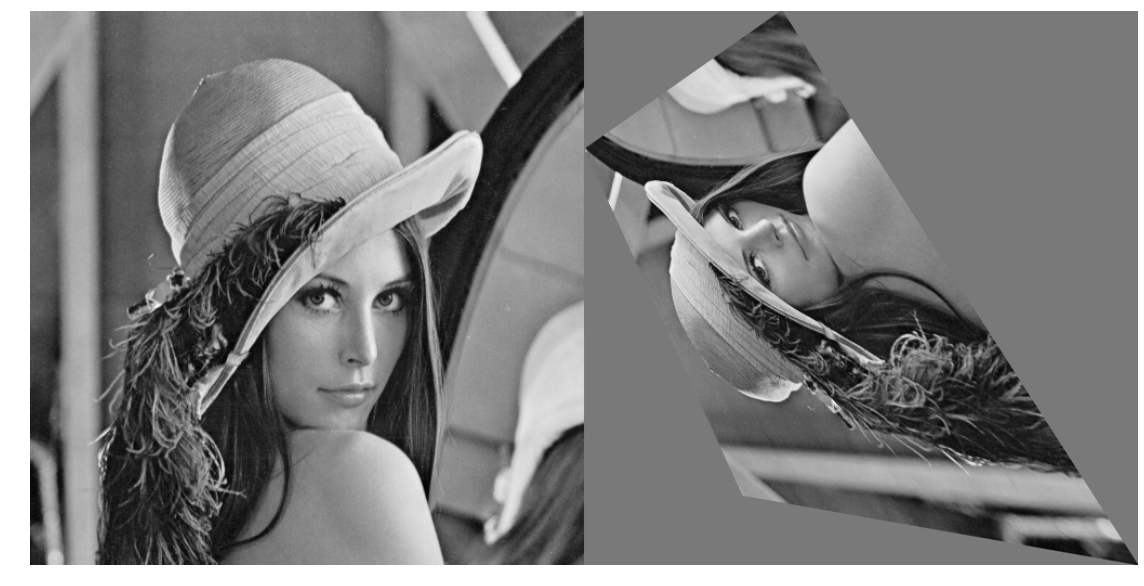

In [5]:
I = cv2.imread('Lenna.png')
I = cv2.cvtColor(I, cv2.COLOR_BGR2GRAY)

I_trans = cv2.imread('Lenna_transformed.png')
I_trans = cv2.cvtColor(I_trans, cv2.COLOR_BGR2GRAY)

I_comb = np.hstack((I, I_trans))


f, ax = plt.subplots(ncols=1)
f.set_size_inches(16, 16)

ax.imshow(I_comb, cmap=plt.get_cmap('gray'))
plt.axis("off")
plt.tight_layout()
plt.show()

## Detection of scale-space extrema

Detect keypoints by using a cascade filtering to identify candidate locations for further examination.
Identify locations and scales that can be repeatably assigned under different views of the same object. $\Rightarrow$ Detect locations that are invariant to scale change can be accomplished by searching for stable features accross all possible scales, using a continuous function of scale known as scale space.

The only possible scale-space kernel is the Gaussian function $G$ (WHY?),
therefor the scale space of an image is defined as:

$$ L(x,y,\sigma) = G(x,y,\sigma)*I(x,y)$$

where $*$ is the convolution in $x$ and $y$ and

$$G(x,y,\sigma)=\frac{1}{2\pi\sigma^2}e^{-(x^2+y^2)/2\sigma^2}$$.

To efficiently detect stable keypoints in scale space one can use scale-space extrema in the DoG function convolved with the image, $D(x,y,\sigma)$, where $k$ is a constant multiplicative factor:

$$D(x,y,\sigma)=(G(x,y,k\sigma)-G(x,y,\sigma))*I(x,y)=L(x,y,k\sigma)-L(x,y,\sigma)$$